# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [2]:
# Your code here
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston


boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
print(df.isnull().sum())
print(df.describe())


Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO          

### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

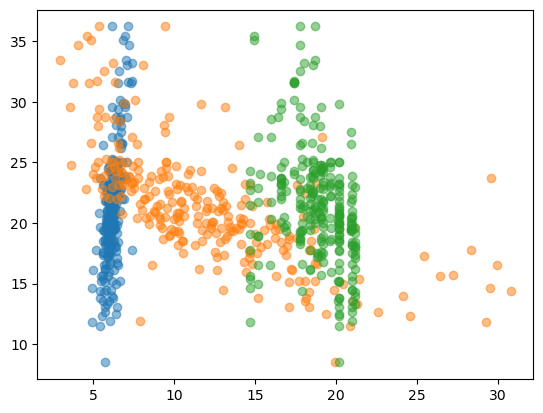

In [11]:
# Your plots here

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

vars_to_plot = ['RM', 'LSTAT', 'PTRATIO']


for var in vars_to_plot:
    
    plt.scatter(df[var], df['MEDV'], alpha=0.5)
    

    model = LinearRegression()
    model.fit(df[[var]], df['MEDV'])
    
  
    plt.plot


### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [ ]:
# Your response here
#There is a strong positive relationship between the average number of rooms per dwelling and the median value of owner-occupied homes. 

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

<AxesSubplot:>

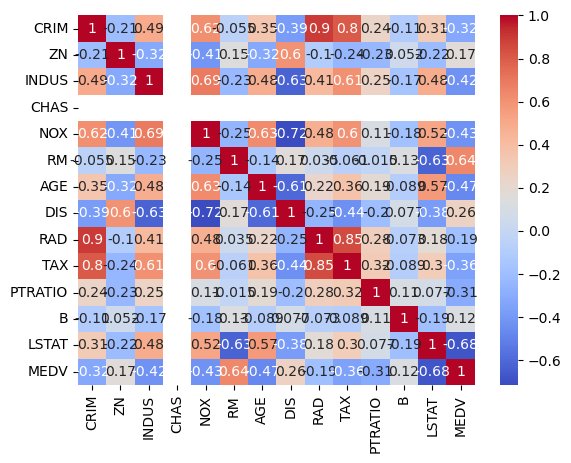

In [13]:
# Your response here

import seaborn as sns
corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')


### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [15]:
# Your code here
stats = df.describe()
stats

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,268.000000,268.000000,268.000000,268.0,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000
mean,1.022245,3.942164,10.664888,0.0,0.534082,6.167108,66.038806,4.011724,7.011194,362.231343,18.802612,389.079813,11.973246,21.397761
std,1.961044,8.687210,6.346300,0.0,0.097127,0.427216,26.723486,1.769263,6.749384,140.349399,1.750728,11.132638,5.408903,4.714913
min,0.006320,0.000000,1.380000,0.0,0.409000,4.903000,2.900000,1.345900,1.000000,188.000000,14.700000,344.910000,2.940000,8.500000
25%,0.086420,0.000000,5.860000,0.0,0.453000,5.890500,45.775000,2.508075,4.000000,277.000000,17.800000,386.740000,7.857500,18.650000
50%,0.171565,0.000000,8.560000,0.0,0.520000,6.127000,70.300000,3.671500,5.000000,307.000000,19.100000,393.520000,11.045000,21.100000
75%,0.596213,0.000000,18.100000,0.0,0.581000,6.422250,90.325000,5.287300,6.000000,403.000000,20.200000,396.900000,14.727500,23.725000
max,8.716750,30.000000,27.740000,0.0,0.871000,7.416000,100.000000,9.222900,24.000000,711.000000,21.200000,396.900000,30.810000,36.200000


----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [20]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """Calculates and returns the performance score between 
    true and predicted values based on the metric chosen."""
    
    score = r2_score(y_true, y_predict)
    return score





### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [21]:
# Your code here
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [22]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

max_depths = [2, 4, 6, 8, 10]
train_scores = []
test_scores = []

for depth in max_depths:

    model = RandomForestRegressor(max_depth=depth, random_state=1)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    
    train_scores.append(train_error)
    test_scores.append(test_error)


Now, plot the score for each tree on the training set and on the testing set.

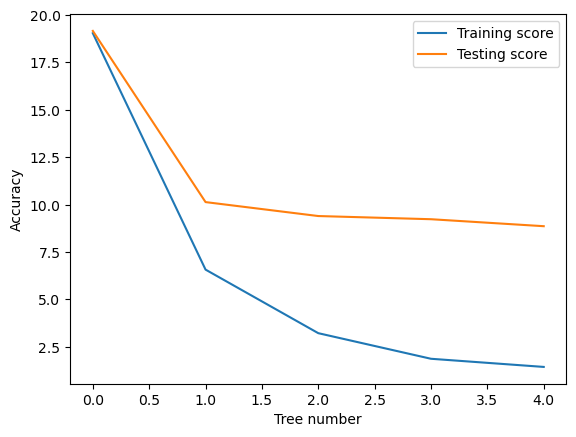

In [23]:
# Produce a plot with the score for the testing and training for the different max depths
import matplotlib.pyplot as plt
plt.plot(train_scores, label='Training score')
plt.plot(test_scores, label='Testing score')
plt.xlabel('Tree number')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? Check out this article before answering: https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

In [ ]:
# Your response here
#When a model is trained with a maximum depth of 1, it typically suffers from high bias and low variance.On the other hand, when a model is trained with a maximum depth of 10, it may suffer from high variance and low bias

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [27]:
# Your response here
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=6)
rf.fit(X_train, y_train)

print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))


ValueError: Unknown label type: 'continuous'

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [ ]:
# Your response here
#The constructed model should not be used in a real-world setting without further investigation and consideration of various factors.

The data used to train the model was collected in 1978, which may not be relevant to today.

The features present in the data, such as the number of rooms, neighborhood, and student-teacher ratio, may not be sufficient to describe a home in the dataset
While the model achieved high accuracy on the training and testing sets, it may not be robust enough to make consistent predictions in a real-world setting due to factors such as data quality, missing features, and changes in the housing market over time.

Finally, data collected in an urban city like Boston may not be applicable in a rural city, as the factors that affect housing prices may be very different in different regions.

